<a href="https://colab.research.google.com/github/khanma1962/Fire-Classification-and-Detection/blob/main/weights_and_biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Classification

###Hyperparameter Tuning with Weights and Biases

https://wandb.ai/site/articles/running-hyperparameter-sweeps-to-pick-the-best-model-using-w-b

https://colab.research.google.com/drive/1K8EQ_ENXEw1uDykCYXo4X7XZgYE8zsVs#scrollTo=r4VjKui20N3j


In [1]:
# copying data from drive to colab Pro for faster simulation

!mkdir clf
!mkdir clf/data
!mkdir clf/data/train
!mkdir clf/data/test
!cp -r /content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/fire_classification/data/train/* clf/data/train/
!cp -r /content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/fire_classification/data/test/* clf/data/test/
!cp -r /content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/fire_classification/data/*.csv clf/data/



In [3]:
!nvidia-smi

Wed Jun 23 20:25:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory

print(virtual_memory().total / 1e9,  'GB')


27.339640832 GB


In [5]:
!pip install wandb -qqq

     |████████████████████████████████| 1.8MB 4.3MB/s 
     |████████████████████████████████| 174kB 53.8MB/s 
     |████████████████████████████████| 133kB 53.6MB/s 
     |████████████████████████████████| 102kB 14.6MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 


In [6]:
# calling all libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
import torch.nn.functional as F
from torchvision import  models, transforms
from torchvision.utils import make_grid
import torch.optim as optim

import os, math
from PIL import Image
from IPython.display import display

# remove run/ dir
# !rm -rf runs/  # remove previous runs
# from torch.utils.tensorboard import SummaryWriter

# import albumentations as alb
# from albumentations.pytorch import ToTensor

import time
import warnings
warnings.filterwarnings('ignore')

import wandb

torch.manual_seed(42)


In [7]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
torch.__version__

'1.9.0+cu102'

### Image files directory tree


<pre>.
└──   fire_classification
        ├── test
        │       ├── Fire_0.jpg
        │       ├── Fire_1.jpg
        │       └── ... (100 files)
        │       ├── No_Fire_0.jpg
        │       ├── No_Fire.jpg
        │       └── ... (100 files)       
        │           
        └── train
                ├── Fire_0.jpg
                ├── Fire_1.jpg
                └── ... (900 files)
                ├── No_Fire_0.jpg
                ├── No_Fire1.jpg
                └── ... (900 files)</pre>

In [9]:
# root dir and naming

# root_dir = '/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/fire_classification/'
root_dir = 'clf'
# print(os.path.join(root_dir))
dir_list = ['train', 'test']

train_labels = pd.read_csv(root_dir + '/data/train.csv')
test_labels  = pd.read_csv(root_dir + '/data/test.csv')
print(train_labels.head())
print('*'*50)
train_path = root_dir + '/data/' + dir_list[0]
test_path  = root_dir + '/data/' + dir_list[1]
has_fire = {1 : 'Fire', 0 : 'No_Fire'}

#check if dataset is balanced
print(train_labels['has_Fire'].value_counts())
print('*'*50)
#checking the number of files in each directories
for (path, dir, files) in os.walk(os.path.join(root_dir + '/data')):
    print(f"{path} has {len(os.listdir(path))} number of files")



     Image_no  has_Fire
0  Fire_0.jpg         1
1  Fire_1.jpg         1
2  Fire_2.jpg         1
3  Fire_3.jpg         1
4  Fire_4.jpg         1
**************************************************
0    999
1    985
Name: has_Fire, dtype: int64
**************************************************
clf/data has 4 number of files
clf/data/train has 1984 number of files
clf/data/test has 170 number of files


In [10]:
train_labels.head()

,Image_no,has_Fire
0,Fire_0.jpg,1
1,Fire_1.jpg,1
2,Fire_2.jpg,1
3,Fire_3.jpg,1
4,Fire_4.jpg,1


In [11]:
len(train_labels)

1984

The type is No_Fire and shape of the image is  (195, 258, 3)


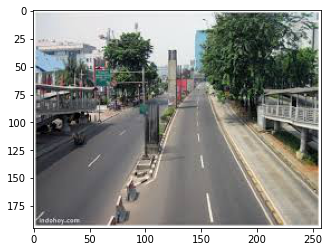

In [12]:
# see the first image

x = np.random.randint(len(train_labels))

fire_jpg = os.listdir(os.path.join(root_dir, 'data/' + 'train/'))[x]
fire_loc = os.path.join(root_dir, 'data/' + 'train/') +'/' + fire_jpg
fire_img = imread(fire_loc)
fire_lbl = has_fire[train_labels[train_labels['Image_no'] == fire_jpg]['has_Fire'].values[0]]
plt.imshow(fire_img)
print(f'The type is {fire_lbl} and shape of the image is  {fire_img.shape}')

### Dataset and Dataloader

In [15]:
# Weight and Bias config
#https://docs.wandb.ai/guides/sweeps/configuration

sweep_config = {
    'method' : 'random',
    'metric' : {'name' : 'loss', 'goal'   : 'minimize'}}

parameters_dict = {
        'optimizer' : { 'values' : ['adam', 'sgd']},
        'mid_layer_size' : {'values' : [256, 512, 1024]},
        'dropout' : {'values' : [0.4, 0.5, 0.6] }}

sweep_config['parameters'] = parameters_dict
                    
                    
parameters_dict.update({
        'epochs' : {'value' : 10},
        'learning_rate': {'distribution' : 'uniform',   'min' : 0.0, 'max' : 0.1},
        'batch_size' : {'distribution': 'q_log_uniform', 'q' : 1, 'min': math.log(32), 'max': math.log(256)} # https://stackoverflow.com/questions/53789280/qloguniform-search-space-setting-issue-in-hyperopt             
        })

sweep_id = wandb.sweep(sweep_config, project= 'pytorch_hp_tuning ')

import pprint
pprint.pprint(sweep_config)

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. {'max': 0.1, 'min': 0, 'distribution': 'uniform'} is not valid under any of the given schemas


Create sweep with ID: a15hf3ib
Sweep URL: https://wandb.ai/khan_m_a/pytorch_hp_tuning%20/sweeps/a15hf3ib
{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'distribution': 'q_log_uniform',
                               'max': 5.545177444479562,
                               'min': 3.4657359027997265,
                               'q': 1},
                'dropout': {'values': [0.4, 0.5, 0.6]},
                'epochs': {'value': 10},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0.0},
                'mid_layer_size': {'values': [256, 512, 1024]},
                'optimizer': {'values': ['adam', 'sgd']}}}


In [14]:
# Creating class Dataset

class FireDataset(torch.utils.data.Dataset):
    "Inhereting Dataset from torch and adding stuff"
    def __init__(self, data, path, transforms=None):
        super().__init__()
        'initialize first'
        # print(list_IDs, labels)
        self.path = path
        self.data = data.values
        self.transforms = transforms


    def __getitem__(self, index):
        'generate one sampe of data'
        #select sample
        img_name, label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = Image.open(img_path)
        image = image.convert('RGB') # https://stackoverflow.com/questions/11064786/get-pixels-rgb-using-pil
        
        if self.transforms is not None:
            image = self.transforms(image)

        return image, label

    
    def __len__(self):
        'indicate total number of samples'
        return len(self.data)


In [18]:
# train function

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(config = None):
    #initliaze a new  run
    with wandb.init(config = config):

        config = wandb.config

        loader = build_dataset(config.batch_size, train_labels, train_path )
        network = build_network(config.mid_layer_size, config.dropout)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate)

        for epoch in range(config.epochs):
            avg_loss = train_epoch(network, loader, optimizer)
            wandb.log({"loss": avg_loss, "epoch": epoch})

def build_dataset(batch_size, train_labels, train_path ):
    transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize( (.1307,), (0.3081,))
                    # mean = [0.485, 0.456, 0.406],
                    # std = [0.229, 0.224, 0.225])                       
            ])
    
    training_set = FireDataset(train_labels, train_path, transforms=transform)
    training_generator = DataLoader(training_set, batch_size= batch_size, shuffle=True)
 
    return training_generator


def build_network(mid_layer_size , dropout ):
    #Pre-trained model
    resnet50_model = models.resnet50(pretrained= True)

    # Freeze feature parameters
    for param in resnet50_model.parameters():
        param.requires_grad = False

    # add a new fc of binary class instead of 1000 classes
    resnet50_model.fc = nn.Sequential(
                                nn.Linear(2048, mid_layer_size),
                                nn.ReLU(),
                                nn.Dropout(dropout),
                                nn.Linear(mid_layer_size, 2),
                                # nn.LogSoftmax(dim=1)).to(device)
                                nn.Sigmoid())
    return resnet50_model.to(device)


def build_optimizer(resnet50_model, optimizer, learning_rate):
    if optimizer == 'sgd':
        optimizer = optim.SGD(resnet50_model.parameters(), 
                              lr= learning_rate, momentum = 0.9)
    elif optimizer == 'adam':
        optimizer = optim.Adam(resnet50_model.parameters(),
                               lr = learning_rate)
    return optimizer


def train_epoch(resnet50_model, training_generator, optimizer):
    cumm_loss = 0
    for _ , (data, target) in enumerate(training_generator):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        # loss = F.nll_loss(resnet50_model(data), target)
        lss = nn.CrossEntropyLoss()
        loss = lss(resnet50_model(data), target)
        cumm_loss += loss.item()

        #backward pass and weight update
        loss.backward()
        optimizer.step()

        wandb.log({"batch loss" : loss.item()})
    
    return cumm_loss / len(training_generator)



In [20]:
# launch an agent

wandb.agent(sweep_id, train, count= 100) #5 )

wandb: Agent Starting Run: wu9wmb3r with config:
wandb: 	batch_size: 37
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.07838967676351048
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.79152
_runtime,152
_timestamp,1624481403
_step,549
loss,0.80961
epoch,9


batch loss,▂▁▂▅▆▆▂▇▄▆▃▆▃▄▇▅▄▇▆▂▆▅▄▆▆▅▃▄▅▆▆▂▄█▃▄▄▄▅▆
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁█████████
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 9nxblvch with config:
wandb: 	batch_size: 39
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.07443100926252738
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,0.81326
_runtime,149
_timestamp,1624481558
_step,519
loss,0.81678
epoch,9


batch loss,▇▆▂▄▂▂▇▂▄▅▅▃▄▅▄▇▁▄▆▇▂▁▇▇▃█▆▆▅▄▅▄▆▄▄▄▂▃▂▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁█████████
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: gnhpfswv with config:
wandb: 	batch_size: 107
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.011367452436891613
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.86499
_runtime,148
_timestamp,1624481714
_step,199
loss,0.81107
epoch,9


batch loss,▁▇▆▇▇▅▅▆▇▇▇▆▆▅▇█▅▇▇▆▇▆▅▆▆▆▆▇▇▆▆▆█▅▅▆▇▅▇▇
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▇██▇█▇█▇█
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: bqxk7lsf with config:
wandb: 	batch_size: 156
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.03477453024370073
wandb: 	mid_layer_size: 256
wandb: 	optimizer: sgd


batch loss,0.32625
_runtime,146
_timestamp,1624481866
_step,139
loss,0.32928
epoch,9


batch loss,██▇▇▅▄▄▃▂▂▂▂▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: eshtomla with config:
wandb: 	batch_size: 41
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 1.41704419950206e-05
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: sgd


batch loss,0.6881
_runtime,149
_timestamp,1624482021
_step,499
loss,0.68591
epoch,9


batch loss,▇▆▅▇▄▅▄▅▄▅▄▇▅█▅▃▇▅▅▅▂█▃▄▃▁▄▅▆▅▂▄▄▃▂▇▄▄▁▄
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▅▆▅▄▄▄▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: qvkav61m with config:
wandb: 	batch_size: 91
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0073090108346824945
wandb: 	mid_layer_size: 512
wandb: 	optimizer: adam


batch loss,0.82011
_runtime,146
_timestamp,1624482174
_step,229
loss,0.80983
epoch,9


batch loss,▁▆█▇▆▇▇▆▇▆▆▆▇▇▅▆▆█▆▅▄▆▇▇▆▆▆█▅▇▆▅▅▇▆▅▆▅▇▆
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁██▇██▇███
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: hg1vcitr with config:
wandb: 	batch_size: 60
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.005740898915490933
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: sgd


batch loss,0.3296
_runtime,148
_timestamp,1624482328
_step,349
loss,0.34216
epoch,9


batch loss,██▇▇▆▅▄▃▄▃▂▂▂▂▂▂▂▁▂▂▁▂▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▃▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: oq7icvte with config:
wandb: 	batch_size: 225
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.07067399190697803
wandb: 	mid_layer_size: 256
wandb: 	optimizer: sgd


batch loss,0.34294
_runtime,148
_timestamp,1624482482
_step,99
loss,0.32761
epoch,9


batch loss,██▇▇▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: yc5bp1xa with config:
wandb: 	batch_size: 109
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.07976651660083045
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.99508
_runtime,147
_timestamp,1624482634
_step,199
loss,0.82398
epoch,9


batch loss,▄▁▄▄▆▆▃▅▅▅▅▄▅▄▇▄▄▄▅▅▅▄▄▅▅▄▅▅▄▄▇▄▅▅▄▄▆▅▅█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▇▇▇▇▇██▇█
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: uka8y30t with config:
wandb: 	batch_size: 148
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.05210926220289678
wandb: 	mid_layer_size: 512
wandb: 	optimizer: adam


batch loss,0.81326
_runtime,146
_timestamp,1624482786
_step,149
loss,0.81664
epoch,9


batch loss,▆▇▅▃▇▅▅▄▆▅▅▄▅▄▅▄▄▃▆▃▇▁▄█▄▆▁▅▅▅▃▅▅▅▅▄▅▄▂▄
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁█▇▆▇▆▇▆▇▇
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: xcts8j4j with config:
wandb: 	batch_size: 238
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0011249260506797532
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.62611
_runtime,153
_timestamp,1624482945
_step,99
loss,0.62914
epoch,9


batch loss,██▇▇▇█▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▆▅▄▄▃▂▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: e4d8mqmr with config:
wandb: 	batch_size: 98
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.042327987543298806
wandb: 	mid_layer_size: 512
wandb: 	optimizer: adam


batch loss,0.85493
_runtime,147
_timestamp,1624483097
_step,219
loss,0.81136
epoch,9


batch loss,▇▄▁▆▄▆▃▆▃▄▅▄▂▇▃▄▄▆▅▃▄▆█▆▅▄▄▄▅▄▆▂▅▇▆▂▅▅▂▆
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▄▁▅▅▅█▃▇▅▆
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: geimwvjb with config:
wandb: 	batch_size: 50
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.09513472596591838
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.72503
_runtime,150
_timestamp,1624483253
_step,409
loss,0.80906
epoch,9


batch loss,▃▂▅▄▂▅▅▄█▄▃▄▁▅▃▁▅▂▅▄▄▃▄▅▅▇▅▂▇▃▃▃▅▃▅▂▆▃█▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▄▂▃▃█▇▅▄▃
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: j54tetil with config:
wandb: 	batch_size: 80
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.07119905054467084
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,0.81326
_runtime,149
_timestamp,1624483409
_step,259
loss,0.80945
epoch,9


batch loss,▄▅▄▅▄▄▁▆▃▄▅▇▄▇▇▅▄▃▃▅▄▃▁▄▄▅▆▇▇▇▂█▆▇▆▅▆▄▆▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁█▆▅▅▆▆▅▆▅
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 0hq7d047 with config:
wandb: 	batch_size: 35
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.07681391549757327
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,0.85493
_runtime,151
_timestamp,1624483566
_step,579
loss,0.80998
epoch,9


batch loss,▄▆▄▇▂▂▁▄▃▅▃▄▃▁▂█▅▄▃▃▁▄▅▄▃█▇▂▅▄▄▅▅▇▁▄▆▄▂▅
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▇▆█▇█▇▇██
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: savqgiaz with config:
wandb: 	batch_size: 36
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.006929500707050407
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,1.06326
_runtime,149
_timestamp,1624483721
_step,569
loss,0.81376
epoch,9


batch loss,▂▂▂▄▄▅▅▃▂▄▅▄▅▃▂▂▂▁▅▄▆▂▂▄▂▄▅▂▅▄▃▃▁▃▄▆▄▁▂█
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▂▆▆▁██▃▆▃█
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: uu9rf9te with config:
wandb: 	batch_size: 229
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.038944163071434085
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,0.89221
_runtime,154
_timestamp,1624483882
_step,99
loss,0.81961
epoch,9


batch loss,▁▄▆▆▅▅▇▆▆▆▅▆▃▄▇▇▆▆▅▄▅▇▅▅▄▅▅▇▅▆▆▄▆▆▅▄█▄▅█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁███▇█▇█▇█
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 3jlhbvpv with config:
wandb: 	batch_size: 82
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.051981150097252085
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: sgd


batch loss,0.31481
_runtime,147
_timestamp,1624484034
_step,259
loss,0.3207
epoch,9


batch loss,█▆▄▃▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 78a2eowc with config:
wandb: 	batch_size: 53
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0876473082859171
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.74804
_runtime,149
_timestamp,1624484190
_step,389
loss,0.80881
epoch,9


batch loss,▆▇█▆▆▄█▄▃▅▁█▅▇▄▇▃▄▅▂▄█▄▃▃▃▄▇▇▆▇▆▇▇▆▅▅▅▆▄
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▃▅▅▂▇█▅▆▄
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 362pq1rw with config:
wandb: 	batch_size: 95
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.06654956967112133
wandb: 	mid_layer_size: 256
wandb: 	optimizer: sgd


batch loss,0.31415
_runtime,148
_timestamp,1624484344
_step,219
loss,0.33231
epoch,9


batch loss,█▇▄▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: ssxgdqpj with config:
wandb: 	batch_size: 74
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.037290818102887015
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.84659
_runtime,149
_timestamp,1624484500
_step,279
loss,0.817
epoch,9


batch loss,▁▄▂▇█▇█▆▆▅▇▅▅▃▆▃▃▇▆▅▇▇▅▄▄▆▇▃▅█▁▇▇▄▅▇▄▄▇▄
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁▇████████
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: g7tuskzi with config:
wandb: 	batch_size: 117
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.007357723462938004
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: sgd


batch loss,0.33606
_runtime,147
_timestamp,1624484653
_step,179
loss,0.34884
epoch,9


batch loss,███▇▇▆▆▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▃▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: ajw93myk with config:
wandb: 	batch_size: 48
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.023499062204562427
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.42697
_runtime,149
_timestamp,1624484808
_step,429
loss,0.32951
epoch,9


batch loss,█▇▄▂▂▁▂▂▂▁▂▁▂▁▂▂▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▃
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: a9euezmb with config:
wandb: 	batch_size: 114
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.026557277947932167
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.33567
_runtime,147
_timestamp,1624484961
_step,189
loss,0.32806
epoch,9


batch loss,██▇▆▄▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 1rqhvmm6 with config:
wandb: 	batch_size: 45
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.056702638477639095
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: sgd


batch loss,0.55359
_runtime,149
_timestamp,1624485117
_step,459
loss,0.33681
epoch,9


batch loss,█▆▃▁▂▁▁▁▂▂▁▁▂▂▁▁▂▁▂▂▂▁▁▁▁▁▁▁▃▁▂▁▂▁▁▃▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▂▁▁▃▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: a2zawru0 with config:
wandb: 	batch_size: 213
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.02776844083616105
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,0.77595
_runtime,154
_timestamp,1624485278
_step,109
loss,0.80742
epoch,9


batch loss,▁▅▆▃▆▅▅▅▄▅▇▄▅▇▄▂▂█▇▅▇▄▆▄▆▆▄▃▃▆▄▅▆▅▅▆█▆▄▄
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁█▇█▇▇█▇█▇
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: d1qrsizs with config:
wandb: 	batch_size: 42
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.08368446702150445
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.31327
_runtime,151
_timestamp,1624485435
_step,489
loss,0.32869
epoch,9


batch loss,█▃▁▂▁▂▁▂▁▂▁▁▃▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: j48u7ort with config:
wandb: 	batch_size: 212
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.06524800383413891
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,0.77379
_runtime,153
_timestamp,1624485596
_step,109
loss,0.81403
epoch,9


batch loss,▁▇▇▇▄▅█▅▆▆▆▆▅▅█▆▆▇▄▇▅▇▆▆▇▆▆█▇▃█▆▅▆▇██▅█▄
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▆▅▇▆█▆▆▆▅
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 6u093eue with config:
wandb: 	batch_size: 110
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.010602637430321915
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,1.06326
_runtime,147
_timestamp,1624485749
_step,199
loss,0.82259
epoch,9


batch loss,▄▂▄▂▂▃▃▃▂▅▂▅▄▃▃▃▃▂▄▃▃▁▁▂▂▂▃▃▂▂▃▅▄▃▄▃▅▂▂█
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▂█▂▆▄▆▄▆▆
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: eohwlfsu with config:
wandb: 	batch_size: 51
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.09905468360001984
wandb: 	mid_layer_size: 512
wandb: 	optimizer: adam


batch loss,0.72631
_runtime,150
_timestamp,1624485905
_step,399
loss,0.8089
epoch,9


batch loss,▄▅▄▃▃▅▄▃▄██▂▄▄▇▃▃▄▁▃▇▁▃▁▂▄▇▅▂▆▃▃▄▇▄▆▇▃▄▆
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▆▆▆▅▅▇█▅█
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 9rw221mi with config:
wandb: 	batch_size: 114
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0509732808697701
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,0.81326
_runtime,147
_timestamp,1624486059
_step,189
loss,0.80985
epoch,9


batch loss,▂▆▅▃▃█▅▆▇▅▅▆▃▅▅▁▃▅▄▃▆█▄▅▄▅▅▆▄▄▃▅▆▆▄▂▃▅▄▅
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▅▇▇▇▇█▇▅▇
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 1dzfiwg1 with config:
wandb: 	batch_size: 208
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.04302124755901169
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,0.57194
_runtime,152
_timestamp,1624486218
_step,109
loss,0.62901
epoch,9


batch loss,█▆▇▆▄▆▅▅▅▅▅▆▇▅▅▄▅▅▅▅▄▅▅▄▅▄▂▁▅▇▇▆▄▄▂▃▅█▇▅
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▇▅▆▆▄▄▁▇▁█
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: ar4jqe2p with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.08991182036891811
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: sgd


batch loss,0.3146
_runtime,148
_timestamp,1624486372
_step,319
loss,0.32289
epoch,9


batch loss,█▆▂▂▁▁▂▃▂▂▂▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 8l71fswt with config:
wandb: 	batch_size: 38
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.06715073159706957
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.69315
_runtime,150
_timestamp,1624486528
_step,539
loss,0.69315
epoch,9


batch loss,▂▃▇▅▅▃▅▅▅▁▅▆▇▃▅▄▄▁█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,████▆▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: clu2k8m3 with config:
wandb: 	batch_size: 51
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.06354068209969842
wandb: 	mid_layer_size: 256
wandb: 	optimizer: sgd


batch loss,0.31377
_runtime,149
_timestamp,1624486685
_step,399
loss,0.32483
epoch,9


batch loss,█▅▂▂▃▃▃▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: fldv36ic with config:
wandb: 	batch_size: 171
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.04898370008074402
wandb: 	mid_layer_size: 256
wandb: 	optimizer: sgd


batch loss,0.32912
_runtime,150
_timestamp,1624486842
_step,129
loss,0.32495
epoch,9


batch loss,██▇▆▅▃▂▂▂▁▂▁▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 4lzdphs9 with config:
wandb: 	batch_size: 96
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.069887481117641
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.31467
_runtime,147
_timestamp,1624486995
_step,219
loss,0.32022
epoch,9


batch loss,█▇▅▃▃▁▂▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: p64kpfbh with config:
wandb: 	batch_size: 108
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.09323800927118772
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,0.69315
_runtime,147
_timestamp,1624487149
_step,199
loss,0.69315
epoch,9


batch loss,█▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁█████████
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 9ddsbayh with config:
wandb: 	batch_size: 116
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.03401169825222683
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.72993
_runtime,148
_timestamp,1624487304
_step,189
loss,0.81246
epoch,9


batch loss,▇▃▆▃▄▄▆▂▃▇▄▁▁▆▃▄▂▂▅▄▄▃▃▆▁▃▃▆▄▃▃▃▁▅█▇▃▄▆▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▆▃██▅▃▅▅▃
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: et1ofhxf with config:
wandb: 	batch_size: 109
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.09310460517089406
wandb: 	mid_layer_size: 512
wandb: 	optimizer: adam


batch loss,0.76781
_runtime,148
_timestamp,1624487459
_step,199
loss,0.80797
epoch,9


batch loss,▁▅▅▇▅▆▅▇▄▄▆▇▄▃▇▇▂▇▂▅▁▄▆▇▃▆▄▄█▅▄▃▄▅▅▆▅▄▃▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▄▄▇▅█▁▅▇█▄
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: sxe6wgje with config:
wandb: 	batch_size: 104
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.03242534660032347
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.81326
_runtime,147
_timestamp,1624487614
_step,209
loss,0.8099
epoch,9


batch loss,▅▂▁▃▄▄▁▇▂▃▁▄▂▂█▄▆▇▄▃▄▆▆▂▂▅▁▅▄▄▆▄▅▃▇▄▄▁▅▄
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▅▃▃▅▅█▃▅▄
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: ys0kv7td with config:
wandb: 	batch_size: 183
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.06726425698541219
wandb: 	mid_layer_size: 512
wandb: 	optimizer: adam


batch loss,0.78729
_runtime,150
_timestamp,1624487772
_step,119
loss,0.80941
epoch,9


batch loss,▁█▇▅▄█▇▆▅▅▇█▄▆▇█▅█▂▃█▆▇▄▅█▅▇▇▆▄▇█▆▇▅▇▄▅▅
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▇█▇█▇██▇█
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: otzfraz5 with config:
wandb: 	batch_size: 47
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.032931017355348424
wandb: 	mid_layer_size: 512
wandb: 	optimizer: adam


batch loss,0.91326
_runtime,150
_timestamp,1624487929
_step,439
loss,0.79579
epoch,9


batch loss,▆▃▄▇▆▇▅█▄▂▇▄▄▄▅▄▇▅▄▁▄▄▄█▅▁█▅▆▆▆▄▃▇▇▄▃▁▂▆
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆█▇▇▇▄▇▆▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: lufawo9s with config:
wandb: 	batch_size: 186
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0689677735028302
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,0.77294
_runtime,151
_timestamp,1624488087
_step,119
loss,0.81516
epoch,9


batch loss,▄▄▁▁▂▂▂▃▅▃▂▃▄▃▃▂▂▂▄▃▃▄▄▄▃▄▄▄▄▃▂▃▇▇██▇▆▇▆
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▁▃▂▂▃▃▂▇█
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: jdkn4whq with config:
wandb: 	batch_size: 50
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0286312546348653
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.69315
_runtime,150
_timestamp,1624488243
_step,409
loss,0.69239
epoch,9


batch loss,▅▄▅█▇▇▆▃▃▄▄█▆█▆▆▅▄▄▅▇▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█████▃▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: iuewbq3e with config:
wandb: 	batch_size: 92
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.09839539513798423
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: sgd


batch loss,0.33071
_runtime,148
_timestamp,1624488397
_step,229
loss,0.32036
epoch,9


batch loss,█▆▄▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 7fecog0c with config:
wandb: 	batch_size: 189
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.030642165232585485
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.32558
_runtime,150
_timestamp,1624488554
_step,119
loss,0.33279
epoch,9


batch loss,███▇▆▆▄▄▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▂▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: v7opj8rt with config:
wandb: 	batch_size: 34
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.022099367025502116
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: sgd


batch loss,0.31344
_runtime,152
_timestamp,1624488713
_step,599
loss,0.34144
epoch,9


batch loss,█▆▃▃▂▂▂▁▃▁▂▅▃▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▂
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: u566991r with config:
wandb: 	batch_size: 41
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.08207707757806214
wandb: 	mid_layer_size: 512
wandb: 	optimizer: adam


batch loss,0.81326
_runtime,151
_timestamp,1624488870
_step,499
loss,0.80978
epoch,9


batch loss,▄▆▃▅▂▅▄▃▆▃▂▆▅▄▂▅▅█▇▆▅▁▆▄▄▅▄▃▆▄▃▅▅▄▅▆▅▆▄▅
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▃▁█▃▄▆▁▄▆▄
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: rtgh0zs4 with config:
wandb: 	batch_size: 36
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.09177673648293463
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,1.06326
_runtime,151
_timestamp,1624489028
_step,569
loss,0.8207
epoch,9


batch loss,▄▃▅▄▄▃▅▃▃▆▄▄▄▅▄▂▁▃▅▅▃▃▄▅▄▅▃▃▆▅▃▄▃▃▄▅▂▄▄█
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁█▇▇▇█▇█▇█
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 8pgrw17t with config:
wandb: 	batch_size: 65
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.08834497190703454
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.84267
_runtime,149
_timestamp,1624489184
_step,319
loss,0.81024
epoch,9


batch loss,▁▃▂▃▃▆▇█▆▆▇▆▄▅▅▄▅▆▅▆▅▅▅▆▅▄▆▄▆▆▅▆▅▅▄▄▅▇▆▆
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁▇████████
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 86i3dy2z with config:
wandb: 	batch_size: 52
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.09470412228439815
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.68826
_runtime,150
_timestamp,1624489341
_step,399
loss,0.8071
epoch,9


batch loss,▃▅▄▂▄▆▂▃█▂▁▃▂▄▅▃▄▇▅▄▆▃▃▂▂▂▂▄▃▃▂▂▅▅▄▇▅▇▄▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▅█▅▁▁▆▃▆▄▃
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: n0ulmrrc with config:
wandb: 	batch_size: 154
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.061023038905360094
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.82061
_runtime,149
_timestamp,1624489497
_step,139
loss,0.80983
epoch,9


batch loss,▄▆▃▄▇▁▃▄▆▅▃▄▂▆▆▁▆▃▅▃▅▃▄▆▅▃▂▄▃▃▄█▅▅▆█▃▃▅▅
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁▇▇▇▆▆█▇▆▇
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: xiop608r with config:
wandb: 	batch_size: 117
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.03793089474612622
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.32687
_runtime,149
_timestamp,1624489653
_step,179
loss,0.32465
epoch,9


batch loss,█▇▆▅▄▃▂▂▁▁▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 7dmjlbyh with config:
wandb: 	batch_size: 55
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0032816260461533634
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.34422
_runtime,150
_timestamp,1624489810
_step,379
loss,0.35709
epoch,9


batch loss,███▇▆▆▆▅▄▅▄▃▃▂▂▂▂▂▂▂▃▂▂▂▁▂▁▂▂▂▁▂▁▂▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▃▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: nz0qx4z6 with config:
wandb: 	batch_size: 225
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.08833112209058186
wandb: 	mid_layer_size: 512
wandb: 	optimizer: adam


batch loss,0.78065
_runtime,157
_timestamp,1624489973
_step,99
loss,0.80914
epoch,9


batch loss,▂▁▆▅▅▆▆▇▇▅▅▇▆█▄▇▆▅▄▇▄▆█▆▄▆▆▆▆▇▆▆▅▆▆▆▅▅█▅
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▇█████▇██
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: advlziom with config:
wandb: 	batch_size: 66
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0731548153762621
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.31326
_runtime,149
_timestamp,1624490129
_step,319
loss,0.32242
epoch,9


batch loss,█▆▃▂▁▂▁▁▄▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: lx46g2ug with config:
wandb: 	batch_size: 36
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.021023807491866532
wandb: 	mid_layer_size: 256
wandb: 	optimizer: sgd


batch loss,0.37
_runtime,149
_timestamp,1624490285
_step,569
loss,0.33469
epoch,9


batch loss,█▇▄▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: ao8vd35i with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0012737429263280033
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.4242
_runtime,148
_timestamp,1624490439
_step,319
loss,0.43243
epoch,9


batch loss,█████▇▇▇▇▇▆▆▆▆▅▆▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇▆▅▄▃▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 3m9zh7uz with config:
wandb: 	batch_size: 35
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.03344678844894335
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.31359
_runtime,152
_timestamp,1624490598
_step,579
loss,0.32778
epoch,9


batch loss,█▄▅▁▂▂▂▂▂▂▁▂▂▁▃▂▁▁▁▁▂▁▁▂▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: q2ivfabb with config:
wandb: 	batch_size: 94
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.047034945663894795
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.69315
_runtime,148
_timestamp,1624490753
_step,229
loss,0.69315
epoch,9


batch loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁█████████
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: xcptxk06 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.005966546362315472
wandb: 	mid_layer_size: 256
wandb: 	optimizer: sgd


batch loss,0.34002
_runtime,152
_timestamp,1624490912
_step,629
loss,0.33662
epoch,9


batch loss,██▆▅▅▃▂▂▁▂▂▂▂▁▂▁▂▁▂▁▁▁▁▂▁▁▁▂▁▂▁▁▂▂▂▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: skp6yte8 with config:
wandb: 	batch_size: 233
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.07611377543539295
wandb: 	mid_layer_size: 256
wandb: 	optimizer: sgd


batch loss,0.32422
_runtime,156
_timestamp,1624491075
_step,99
loss,0.32564
epoch,9


batch loss,██▇▆▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: gqict26k with config:
wandb: 	batch_size: 242
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.05328905573813733
wandb: 	mid_layer_size: 256
wandb: 	optimizer: sgd


batch loss,0.32674
_runtime,156
_timestamp,1624491238
_step,99
loss,0.32711
epoch,9


batch loss,██▇▇▆▅▃▃▂▂▂▂▁▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: gsfmtb3s with config:
wandb: 	batch_size: 216
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.09716769168065098
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: sgd


batch loss,0.32473
_runtime,156
_timestamp,1624491401
_step,109
loss,0.3242
epoch,9


batch loss,██▆▅▃▂▂▂▂▂▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: p0dx7jgc with config:
wandb: 	batch_size: 49
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.011169383098588682
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.42406
_runtime,151
_timestamp,1624491560
_step,419
loss,0.48015
epoch,9


batch loss,▃▄▃▄▁▂▁▂▂▁▂▂▃▃▁▃▃▂▃█▇▇▃▆▃▃▄▄▄▂▃▃▃▃▄▂▂▁▂▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▃▁▁▂▅█▃▃▂▂
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: n186zqoj with config:
wandb: 	batch_size: 95
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01707082556890546
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.80136
_runtime,148
_timestamp,1624491717
_step,219
loss,0.8167
epoch,9


batch loss,▇▂▃▄▅▄▇▂█▅█▃▂▄▅▄▅▂█▅▆▅▅▄▃▇▅▁▆▇▆▅▂▇▄▇▃▄▃▄
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▆▃▅█▄▅▅▁▇▄
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 5zcfth9l with config:
wandb: 	batch_size: 59
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.07341926247750749
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.36856
_runtime,149
_timestamp,1624491873
_step,349
loss,0.33245
epoch,9


batch loss,█▅▄▁▁▁▂▂▁▁▁▂▁▂▁▂▁▂▁▁▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: cpcaw886 with config:
wandb: 	batch_size: 234
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0799434551863333
wandb: 	mid_layer_size: 256
wandb: 	optimizer: sgd


batch loss,0.32038
_runtime,156
_timestamp,1624492036
_step,99
loss,0.32525
epoch,9


batch loss,██▇▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: s4ktsrxe with config:
wandb: 	batch_size: 107
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.037079250038880344
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,0.8305
_runtime,149
_timestamp,1624492192
_step,199
loss,0.81023
epoch,9


batch loss,▂▂▆▄▅▃▄▆▄▅▄▃▃▃▆▃▂▂▂▂▅▅█▂▇▂▁▄▄▂▅▃▅▁▂▃█▄▂▅
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▆▇▆█▇▆▆██
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: sq1o9uez with config:
wandb: 	batch_size: 39
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.07811767842446149
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,0.81326
_runtime,151
_timestamp,1624492351
_step,519
loss,0.81678
epoch,9


batch loss,▃▅▅▆▅▆▇▄▄▇▆▇█▇▇▇▅▆█▂▄▇▃▅▇▆▄▄▄▄█▇▅▃▂▇▅▆▁▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁█████████
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: lmi3wo1x with config:
wandb: 	batch_size: 166
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.04379475887217628
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.32778
_runtime,150
_timestamp,1624492509
_step,129
loss,0.3255
epoch,9


batch loss,██▇▆▅▄▃▃▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: e5armsyg with config:
wandb: 	batch_size: 80
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.05031604829472727
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,0.69315
_runtime,148
_timestamp,1624492664
_step,259
loss,0.69315
epoch,9


batch loss,▁▁▇▇▇▆█▆▆▅▄▇▆▄▃▃▃▃▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▃██▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: wzxhog3d with config:
wandb: 	batch_size: 228
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00998086952878764
wandb: 	mid_layer_size: 512
wandb: 	optimizer: adam


batch loss,0.85701
_runtime,156
_timestamp,1624492829
_step,99
loss,0.81812
epoch,9


batch loss,▁▆▅█▇▅▅▃▆▅▆▆▆▅▅▆█▄▅▇▅▄▆█▄▅█▆▅▆▆▇▅▆▅▅▅▅▆▇
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁█████████
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: rcodic7x with config:
wandb: 	batch_size: 65
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.052307503480955746
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.81326
_runtime,150
_timestamp,1624492986
_step,319
loss,0.80979
epoch,9


batch loss,▅▅▅▅▆▄▅▅▅▅▅▇▃▅▆▁▅▄▃▆▆▆▆▄▅▃▆▄▄▄▅▄▅▆▅▃▃▆▄█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁▇▅▂█▄▄▃▂▄
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: d5u3mk64 with config:
wandb: 	batch_size: 60
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.023631884237188164
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.31337
_runtime,151
_timestamp,1624493144
_step,349
loss,0.34779
epoch,9


batch loss,█▇▆▃▂▂▂▂▂▂▃▂▂▂▂▂▃▁▁▁▁▁▁▂▂▂▁▂▁▁▁▂▁▁▁▁▂▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▂
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 4c0t57bn with config:
wandb: 	batch_size: 172
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.07255048981779914
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,0.76978
_runtime,150
_timestamp,1624493301
_step,129
loss,0.80818
epoch,9


batch loss,▁▆▅▃▆▄▆▇▆▆▅█▅▅▆▅▄▇▅█▆▆▆▄█▄▆▇▆▅▆▆▆▇▅▆▅▄▆▄
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁▃▅▆█▅▆▆▅▅
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: ladoi060 with config:
wandb: 	batch_size: 41
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.06720249424673781
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.32
_runtime,151
_timestamp,1624493460
_step,499
loss,0.32654
epoch,9


batch loss,█▃▂▁▁▂▂▁▂▁▂▂▁▂▁▁▂▂▁▁▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▄▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: hqwreek0 with config:
wandb: 	batch_size: 169
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.09353585201738435
wandb: 	mid_layer_size: 512
wandb: 	optimizer: adam


batch loss,0.77726
_runtime,150
_timestamp,1624493618
_step,129
loss,0.80903
epoch,9


batch loss,▁▆▄▅▅▅█▂▅▃▃▄▂▇▄▃▄▆▃▆▆▂▆▇▆▅▆▅▄▄▂▅▆▅▆▂▅▄█▄
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁▅██▇▇███▇
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: kxih7pfk with config:
wandb: 	batch_size: 58
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.08808416344243397
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.8966
_runtime,150
_timestamp,1624493775
_step,359
loss,0.8186
epoch,9


batch loss,▄▁▃█▃▃▃▃▄▄▄▃▂▅▄▄▄▄▃▄▂▅▂▄▂▂▁▃▃▅▅▃▄▃▄▂▄▅▄▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▇▂▅█▅▂▅▄▁▇
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 2zbbpchp with config:
wandb: 	batch_size: 75
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.08960902066146807
wandb: 	mid_layer_size: 512
wandb: 	optimizer: adam


batch loss,0.72503
_runtime,150
_timestamp,1624493933
_step,279
loss,0.81493
epoch,9


batch loss,▄█▁▅▃▃█▇▃▄▅▃▃▃▄▆▆▃▄▆▆▇▅▂▁▅▂▆▅▂▃▃▅▅▁▃▄▅▃▅
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁▇█▇▆▆▇▇▇▆
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: lqcnyt50 with config:
wandb: 	batch_size: 232
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0389014088737696
wandb: 	mid_layer_size: 256
wandb: 	optimizer: sgd


batch loss,0.32258
_runtime,156
_timestamp,1624494097
_step,99
loss,0.33008
epoch,9


batch loss,███▇▆▅▄▄▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▂▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 26z0048v with config:
wandb: 	batch_size: 199
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0058085222370303675
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: sgd


batch loss,0.38364
_runtime,153
_timestamp,1624494257
_step,109
loss,0.39325
epoch,9


batch loss,████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▅▄▃▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: vmh5tnqe with config:
wandb: 	batch_size: 68
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.024597080556862595
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.40649
_runtime,150
_timestamp,1624494415
_step,309
loss,0.32651
epoch,9


batch loss,██▆▃▄▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: jyeo2huq with config:
wandb: 	batch_size: 34
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.010003063521896949
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,0.72993
_runtime,154
_timestamp,1624494579
_step,599
loss,0.80886
epoch,9


batch loss,▄▄▇▄▂▃▅▅█▅▄▆█▇▁▇▂▄▅▄▃▇▄▄▄▃▅▅█▄▅▆▄▄▄▆▅▄▇▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▅▁▁▇▃█▆▅▇▃
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: cx14md7z with config:
wandb: 	batch_size: 103
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.011489437663725023
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,0.32733
_runtime,149
_timestamp,1624494737
_step,209
loss,0.34457
epoch,9


batch loss,█▄▄▄▃▃▂▂▂▂▂▁▁▂▁▁▁▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▂▃▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 5y0hhwx1 with config:
wandb: 	batch_size: 214
wandb: 	dropout: 0.6
wandb: 	epochs: 10
wandb: 	learning_rate: 0.07557029134488634
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.31728
_runtime,157
_timestamp,1624494902
_step,109
loss,0.32348
epoch,9


batch loss,██▇▆▄▃▃▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: cocijudp with config:
wandb: 	batch_size: 121
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.09963825176952229
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.93826
_runtime,149
_timestamp,1624495060
_step,179
loss,0.8211
epoch,9


batch loss,▄▆▁▅▄▅▅▄▄▂▄▅▄▅▇▅▅▅▅▃▇▄▆▆▄▄▅▄▃▃▃▄▃▆▄▃▆▃▅█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▇▇▇█▆▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: f1yhewmj with config:
wandb: 	batch_size: 106
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01977357206774051
wandb: 	mid_layer_size: 256
wandb: 	optimizer: sgd


batch loss,0.34029
_runtime,149
_timestamp,1624495218
_step,199
loss,0.32835
epoch,9


batch loss,██▇▆▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: pz234mgo with config:
wandb: 	batch_size: 173
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01055985874785097
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.34395
_runtime,152
_timestamp,1624495379
_step,129
loss,0.34915
epoch,9


batch loss,████▇▇▆▆▆▅▄▄▄▃▃▃▂▂▂▂▂▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▅▃▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: nm1m3gnu with config:
wandb: 	batch_size: 251
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.029896880623433056
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: sgd


batch loss,0.33759
_runtime,156
_timestamp,1624495542
_step,89
loss,0.33295
epoch,9


batch loss,██▇▇▆▆▅▅▄▃▃▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▃▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: b0w4cc8e with config:
wandb: 	batch_size: 39
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.09831003836310184
wandb: 	mid_layer_size: 256
wandb: 	optimizer: sgd


batch loss,0.31351
_runtime,152
_timestamp,1624495702
_step,519
loss,0.32994
epoch,9


batch loss,█▂▁▂▂▂▂▄▁▁▂▁▂▁▂▁▁▂▂▁▁▄▁▁▃▂▁▂▁▁▁▁▁▂▁▂▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 4t6b08kb with config:
wandb: 	batch_size: 62
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.09748993469043428
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.31434
_runtime,149
_timestamp,1624495859
_step,329
loss,0.32301
epoch,9


batch loss,█▃▄▂▁▁▁▁▁▂▁▂▂▁▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: wzm2ix86 with config:
wandb: 	batch_size: 89
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.05763179883559956
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,1.04403
_runtime,149
_timestamp,1624496016
_step,239
loss,0.81694
epoch,9


batch loss,▃▄▁▃▃▃▁▂▂▂▄▂▃▃▃▂▄▄▂▆▁▃▃▃▄▃▁▃▂▃▄▅▂▂▃▃▁▂▄█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▆▄▅▄▅▄▄▇█
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 63vcvh48 with config:
wandb: 	batch_size: 187
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.05406980582144421
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: adam


batch loss,0.82203
_runtime,152
_timestamp,1624496176
_step,119
loss,0.81698
epoch,9


batch loss,▁▇▄▄▇▅▅▄▅▄▃▇▆▇▆▄▇▅▄▇▅▇▅▅▆▅▂█▃▅▅▅▇▄▄▇▃▅▆▆
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▇█▇▆▇██▇▇
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: bgjk18pr with config:
wandb: 	batch_size: 45
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0412728562531485
wandb: 	mid_layer_size: 512
wandb: 	optimizer: adam


batch loss,0.81326
_runtime,150
_timestamp,1624496335
_step,459
loss,0.8098
epoch,9


batch loss,▄▁▃▄▃▄▆█▇▁▄▂▅▄▅▇▅▃▃▂▂▇▄▇▃▄▄▇▇▁▄▅▇▅▃▇▇▃▄▅
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▅▅▅█▅▅▅▂▅
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 1bn77p24 with config:
wandb: 	batch_size: 83
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.059903712153819594
wandb: 	mid_layer_size: 1024
wandb: 	optimizer: sgd


batch loss,0.31396
_runtime,149
_timestamp,1624496492
_step,249
loss,0.32141
epoch,9


batch loss,█▆▃▂▂▂▁▁▁▁▂▂▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: k9a14vym with config:
wandb: 	batch_size: 67
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.012419327198169183
wandb: 	mid_layer_size: 512
wandb: 	optimizer: sgd


batch loss,0.34036
_runtime,150
_timestamp,1624496651
_step,309
loss,0.33064
epoch,9


batch loss,██▇▆▄▃▂▂▂▂▂▂▂▁▁▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: v0cjm0nd with config:
wandb: 	batch_size: 244
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0016354078721799949
wandb: 	mid_layer_size: 512
wandb: 	optimizer: adam


batch loss,0.3348
_runtime,156
_timestamp,1624496815
_step,99
loss,0.32466
epoch,9


batch loss,█▆▄▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: rfzvni7z with config:
wandb: 	batch_size: 43
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.09263505188606334
wandb: 	mid_layer_size: 256
wandb: 	optimizer: adam


batch loss,0.6466
_runtime,152
_timestamp,1624496974
_step,479
loss,0.78008
epoch,9


batch loss,▅▁▄▃▇▅▅▅▅▅▅▄▆█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▇▇▇
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▂▂▂▂▂▂▂▂█
epoch,▁▂▃▃▄▅▆▆▇█


In [ ]:
# check the size of batch size and format

# for images, labels in build_dataset(16,  train_labels, train_path):
#     break

# print(images.shape, [has_fire[l] for l in labels.numpy()])
